In [1]:
import os, json, numpy as np, pandas as pd
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Transformers & Datasets
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)

TRAIN_PATH = "../data/processed/drugsComTrain_clean_labeled.tsv"
TEST_PATH  = "../data/processed/drugsComTest_clean_labeled.tsv"

ARTIF_DIR  = "../artifacts/distilbert_binary"
FIG_DIR    = "../reports/figures"
os.makedirs(ARTIF_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

MODEL_NAME = "distilbert-base-uncased"   
MAX_LEN    = 256 


In [ ]:
df_train = pd.read_csv(TRAIN_PATH, sep="\t")
df_test  = pd.read_csv(TEST_PATH,  sep="\t")

# Keep only the columns we need for modeling
cols_needed = ["review_clean", "label_bin"]
df_train = df_train[cols_needed].dropna().copy()
df_test  = df_test[cols_needed].dropna().copy()

# Rename label column to 'labels' 
df_train = df_train.rename(columns={"label_bin": "labels"})
df_test  = df_test.rename(columns={"label_bin": "labels"})

# Create a small validation split (10%) from TRAIN, stratified by labels
from sklearn.model_selection import train_test_split
df_tr, df_val = train_test_split(
    df_train, test_size=0.10, stratify=df_train["labels"], random_state=SEED
)

print(f"Train rows: {len(df_tr):,} | Val rows: {len(df_val):,} | Test rows: {len(df_test):,}")


Train rows: 145,167 | Val rows: 16,130 | Test rows: 53,766


In [3]:
ds_tr  = Dataset.from_pandas(df_tr.reset_index(drop=True))
ds_val = Dataset.from_pandas(df_val.reset_index(drop=True))
ds_te  = Dataset.from_pandas(df_test.reset_index(drop=True))

ds_tr, ds_val, ds_te


(Dataset({
     features: ['review_clean', 'labels'],
     num_rows: 145167
 }),
 Dataset({
     features: ['review_clean', 'labels'],
     num_rows: 16130
 }),
 Dataset({
     features: ['review_clean', 'labels'],
     num_rows: 53766
 }))

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(
        batch["review_clean"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    )

# Map tokenization over each split; keep labels; drop raw text columns for training
tok_tr  = ds_tr.map(tokenize, batched=True, remove_columns=["review_clean"])
tok_val = ds_val.map(tokenize, batched=True, remove_columns=["review_clean"])
tok_te  = ds_te.map(tokenize, batched=True, remove_columns=["review_clean"])

# Set the format so PyTorch tensors are returned in the Trainer
tok_tr.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tok_val.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tok_te.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print(tok_tr)


Map:   0%|          | 0/145167 [00:00<?, ? examples/s]

Map:   0%|          | 0/16130 [00:00<?, ? examples/s]

Map:   0%|          | 0/53766 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 145167
})


In [ ]:
# Mixed precision on CUDA if available
use_fp16 = torch.cuda.is_available()

args = TrainingArguments(
    output_dir=ARTIF_DIR,
    num_train_epochs=2,                 
    per_device_train_batch_size=16,     
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",   
    greater_is_better=True,
    fp16=use_fp16,
    seed=SEED,
    report_to="none",                 
    logging_steps=50
)

print(f"Using fp16: {use_fp16} | Device: {'CUDA' if torch.cuda.is_available() else 'CPU/MPS'}")


Using fp16: False | Device: CPU/MPS


/home/ramy/miniforge3/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    macro = f1_score(labels, preds, average="macro")
    f1_neg = f1_score(labels, preds, pos_label=0)
    f1_pos = f1_score(labels, preds, pos_label=1)
    return {
        "accuracy": acc,
        "macro_f1": macro,
        "f1_neg": f1_neg,
        "f1_pos": f1_pos
    }


In [7]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tok_tr,
    eval_dataset=tok_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

train_out = trainer.train()
print("Training finished. Best checkpoint:", trainer.state.best_model_checkpoint)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_13730/4159843094.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,F1 Neg,F1 Pos
1,0.277100,0.291316,0.884935,0.879174,0.852792,0.905557
2,0.218500,0.290372,0.901426,0.896497,0.873910,0.919084


Training finished. Best checkpoint: ../artifacts/distilbert_binary/checkpoint-18146


In [8]:
test_metrics = trainer.evaluate(eval_dataset=tok_te)
print("Test metrics:", test_metrics)

# Save metrics as JSON 
with open(os.path.join(ARTIF_DIR, "metrics_test.json"), "w") as f:
    json.dump({k: float(v) for k, v in test_metrics.items()}, f, indent=2)


Test metrics: {'eval_loss': 0.2706884741783142, 'eval_accuracy': 0.9055350965294052, 'eval_macro_f1': 0.9010334368662583, 'eval_f1_neg': 0.8799262393910021, 'eval_f1_pos': 0.9221406343415143, 'eval_runtime': 2846.4479, 'eval_samples_per_second': 18.889, 'eval_steps_per_second': 0.591, 'epoch': 2.0}


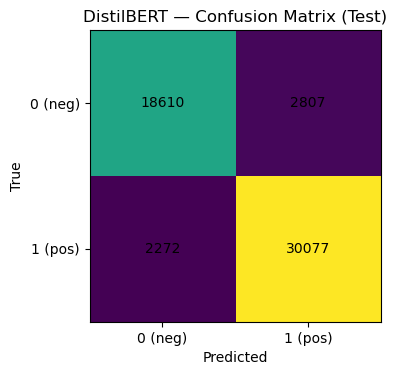

Saved confusion matrix → ../reports/figures/distilbert_confusion_matrix.png


In [11]:
pred = trainer.predict(tok_te)
y_true = pred.label_ids
y_pred = pred.predictions.argmax(axis=-1)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("DistilBERT — Confusion Matrix (Test)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["0 (neg)", "1 (pos)"]); ax.set_yticklabels(["0 (neg)", "1 (pos)"])
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
plt.tight_layout()

out_fig = os.path.join(FIG_DIR, "distilbert_confusion_matrix.png")
plt.savefig(out_fig, dpi=150)
plt.show()
print(f"Saved confusion matrix → {out_fig}")


In [12]:
# Save the fine-tuned model and tokenizer 
save_dir = os.path.join(ARTIF_DIR, "final")
trainer.save_model(save_dir)      
tokenizer.save_pretrained(save_dir)

print("Saved model/tokenizer to:", save_dir)

Saved model/tokenizer to: ../artifacts/distilbert_binary/final
